In [5]:
### import libs
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
import heapq

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
import heapq

class GraphConstructionDiscretization:
    """
    Constructs a graph based on circle discretization and edge feasibility.
    
    Attributes:
        map_qz (list of tuples): Each tuple (cx, cy, radius) represents a circle.
        start (tuple): (x, y) coordinates of the start point.
        goal (tuple): (x, y) coordinates of the goal point.
        q_min, q_max, q_act: Numeric parameters.
        alpha, beta: Parameters for feasibility computations.
        discretization_angle (float): Angle step (in degrees) for discretization.
    """
    def __init__(self, map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle):
        self.map_qz = map_qz
        self.start = start
        self.goal = goal
        self.q_min = q_min
        self.q_max = q_max
        self.q_act = q_act
        self.alpha = alpha
        self.beta = beta
        self.discretization_angle = discretization_angle

    def create_nodes(self):
        """
        Discretizes the circles and creates nodes with start labeled as "s" and goal as "g".
        
        Returns:
            node_positions (np.ndarray): Each row is [x, y, circle_index, q_act].
            index_map (dict): Maps (x, y, circle_index, q_act) to a node key.
            reverse_index_map (dict): Reverse mapping from node key to (x, y, circle_index, q_act).
        """
        angles = np.deg2rad(np.arange(0, 360 + self.discretization_angle, self.discretization_angle))
        num_points_per_circle = len(angles)
        total_nodes = len(self.map_qz) * num_points_per_circle + 2
        node_positions = np.zeros((total_nodes, 4))

        # Use custom keys for start and goal: "s" for start and "g" for goal.
        index_map = {
            (self.start[0], self.start[1], 0, self.q_act): "s",
            (self.goal[0], self.goal[1], len(self.map_qz) + 1, self.q_act): "g"
        }
        reverse_index_map = {
            "s": (self.start[0], self.start[1], 0, self.q_act),
            "g": (self.goal[0], self.goal[1], len(self.map_qz) + 1, self.q_act)
        }

        # Assign start and goal positions in the node array.
        node_positions[0] = [self.start[0], self.start[1], 0, self.q_act]
        node_positions[1] = [self.goal[0], self.goal[1], len(self.map_qz) + 1, self.q_act]

        node_index = 2  # start index for circle nodes
        for circle_index, (cx, cy, radius) in enumerate(self.map_qz, start=1):
            x_vals = cx + radius * np.cos(angles)
            y_vals = cy + radius * np.sin(angles)
            node_positions[node_index:node_index + num_points_per_circle, 0] = x_vals
            node_positions[node_index:node_index + num_points_per_circle, 1] = y_vals
            node_positions[node_index:node_index + num_points_per_circle, 2] = circle_index
            node_positions[node_index:node_index + num_points_per_circle, 3] = self.q_act
            
            for j in range(num_points_per_circle):
                key = (x_vals[j], y_vals[j], circle_index, self.q_act)
                index_map[key] = node_index + j
                reverse_index_map[node_index + j] = key
            node_index += num_points_per_circle

        self.node_positions = node_positions
        return node_positions, index_map, reverse_index_map

    @staticmethod
    def point_to_segment_distance(px, py, x1, y1, x2, y2):
        """
        Computes the minimum distance from point (px, py) to the line segment defined by (x1, y1) and (x2, y2).
        """
        A = px - x1
        B = py - y1
        C = x2 - x1
        D = y2 - y1

        dot = A * C + B * D
        len_sq = C * C + D * D
        param = dot / len_sq if len_sq != 0 else -1

        if param < 0:
            xx, yy = x1, y1
        elif param > 1:
            xx, yy = x2, y2
        else:
            xx, yy = x1 + param * C, y1 + param * D

        dx = px - xx
        dy = py - yy
        return np.sqrt(dx * dx + dy * dy)
    
    def line_segment_intersects_circle(self, circle, point1, point2):
        """
        Checks if the line segment (point1 to point2) intersects the given circle.
        
        Args:
            circle (tuple): (center_x, center_y, radius)
            point1 (tuple): (x1, y1)
            point2 (tuple): (x2, y2)
            
        Returns:
            bool: True if the segment intersects the circle, False otherwise.
        """
        center_x, center_y, radius = circle
        x1, y1 = point1
        x2, y2 = point2
        return self.point_to_segment_distance(center_x, center_y, x1, y1, x2, y2) < radius

    def _compute_edge_parameters(self, soc_i, soc_j, distance):
        """
        Computes feasibility, lambda (λ) value, and line segment parameters for an edge.
        
        Args:
            soc_i (float): State of charge at node i.
            soc_j (float): State of charge at node j.
            distance (float): Euclidean distance between node i and node j.
            
        Returns:
            tuple: (feasible (bool), lamb (float or None), line_segment (dict))
        """
        feasible = False
        line_segment = {}
        
        # Check if the SOC requirements immediately rule out feasibility
        if soc_j > min(self.q_max, soc_i + self.beta * distance):
            return feasible, None, line_segment
        
        # If the drop is sufficiently steep that the whole edge is "feasible"
        if (soc_i - self.alpha * distance) < self.q_min and soc_j <= soc_i - self.alpha * distance:
            feasible = True
            lamb = 1
            line_segment = {"e": (0, lamb)}
        else:
            lamb_1 = (self.q_max - soc_i) / (self.beta * distance)
            lamb_2 = (self.q_max - soc_j) / (self.alpha * distance)
            
            if lamb_1 >= 0 and lamb_2 >= 0 and (lamb_1 + lamb_2 <= 1):
                lamb = lamb_1 + self.alpha / (self.beta + self.alpha) * (1 - lamb_1 - lamb_2)
                lamb_2_sw = lamb_2 + self.beta / (self.beta + self.alpha) * (1 - lamb_1 - lamb_2)
                # Note: using the key "g" twice in a dict will override; if multiple segments are needed,
                # consider using a list of segments.
                line_segment = {"g": (0, lamb_1), "e": (lamb_1, lamb_2_sw), "g2": (lamb_2_sw, 1)}
            else:
                lamb = (soc_j - soc_i + self.alpha * distance) / ((self.alpha + self.beta) * distance)
                line_segment = {"g": (0, lamb), "e": (lamb, 1)}
            if 0 <= lamb <= 1:
                feasible = True
                
        return feasible, lamb, line_segment

    def external_edge_addition(self, i, node_i, j, node_j, visibility_graph):
        """
        Adds an external edge to the visibility graph if the edge is feasible.
        
        Args:
            i (int): Node index for node_i.
            node_i (array-like): Information for node i.
            j (int): Node index for node_j.
            node_j (array-like): Information for node j.
            visibility_graph (networkx.Graph): The graph to update.
            
        Returns:
            networkx.Graph: The updated visibility graph.
        """
        distance = np.linalg.norm(np.array(node_i[:2]) - np.array(node_j[:2]))
        soc_i, soc_j = int(node_i[3]), int(node_j[3])
        
        feasible, lamb, line_segment = self._compute_edge_parameters(soc_i, soc_j, distance)
        
        if feasible:
            cost = lamb * distance
            visibility_graph.add_edge(
                i, j,
                node_i_info=node_i,
                node_j_info=node_j,
                line_segment=line_segment,
                fuel_cost=cost,
                risk_cost=0,
                feasibility=feasible,
                edge_type="external"
            )
        return visibility_graph

    def internal_edge_addition(self, i, node_i, j, node_j, visibility_graph):
        """
        Adds an internal edge (within a circle) to the visibility graph if the edge is feasible.
        Also computes a risk cost for the edge.
        
        Args:
            i (int): Node index for node_i.
            node_i (array-like): Information for node i.
            j (int): Node index for node_j.
            node_j (array-like): Information for node j.
            visibility_graph (networkx.Graph): The graph to update.
            
        Returns:
            networkx.Graph: The updated visibility graph.
        """
        distance = np.linalg.norm(np.array(node_i[:2]) - np.array(node_j[:2]))
        soc_i, soc_j = int(node_i[3]), int(node_j[3])
        
        # Retrieve circle parameters corresponding to node_i (assumes node_i[2] is valid)
        circle = self.map_qz[int(node_i[2] - 1)]
        _, _, radius = circle
        pen_dist = sp.sqrt(radius**2 - (distance / 2)**2)
        
        feasible, lamb, line_segment = self._compute_edge_parameters(soc_i, soc_j, distance)
        
        if feasible:
            cost = lamb * distance
            risk_cost = self._compute_risk_cost(line_segment, pen_dist, distance)
            visibility_graph.add_edge(
                i, j,
                node_i_info=node_i,
                node_j_info=node_j,
                line_segment=line_segment,
                fuel_cost=cost,
                risk_cost=risk_cost,
                feasibility=feasible,
                edge_type="internal"
            )
        return visibility_graph

    def _compute_risk_cost(self, line_segment, pen_dist, distance):
        """
        Computes the risk cost for an internal edge based on the line segment parameters.
        
        Args:
            line_segment (dict): Contains segments with keys (e.g. "g", "e").
            pen_dist: Penetration distance (symbolic) computed from the circle.
            distance (float): Euclidean distance between the two nodes.
            
        Returns:
            risk_cost (sympy expression): The computed risk cost.
        """
        risk_cost = 0
        constant_factor = 30
        factor = 1 / (pen_dist + 0.01)
        
        for key, (lamb_start, lamb_end) in line_segment.items():
            if key == "e":
                continue  # 'e' segments do not contribute to risk cost
            elif key.startswith("g"):
                if lamb_start <= 0.5 <= lamb_end:
                    risk_cost += abs(
                        factor * (
                            sp.atan((distance/2 - lamb_start * distance) / (pen_dist + 0.01)) +
                            sp.atan((lamb_end * distance - distance/2) / (pen_dist + 0.01))
                        )
                    )
                elif lamb_start >= 0.5:
                    risk_cost += abs(
                        factor * (
                            sp.atan((lamb_end * distance - distance/2) / (pen_dist + 0.01)) -
                            sp.atan((lamb_start * distance - distance/2) / (pen_dist + 0.01))
                        )
                    )
                elif lamb_end <= 0.5:
                    risk_cost += abs(
                        factor * (
                            sp.atan((distance/2 - lamb_start * distance) / (pen_dist + 0.01)) -
                            sp.atan((distance/2 - lamb_end * distance) / (pen_dist + 0.01))
                        )
                    )
        return constant_factor * risk_cost

All states: ['s', 22, 23, 24, 25, 26, 27, 'g', 41, 42, 46, 47, 48, 49, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 56, 57, 58, 62, 63, 65, 66, 67, 68, 55, 54, 53, 70, 39, 40, 43, 44, 45, 50, 51, 52, 59, 60, 61, 64, 69, 71, 72, 73, 74, 75]
Dominated solution indices: []


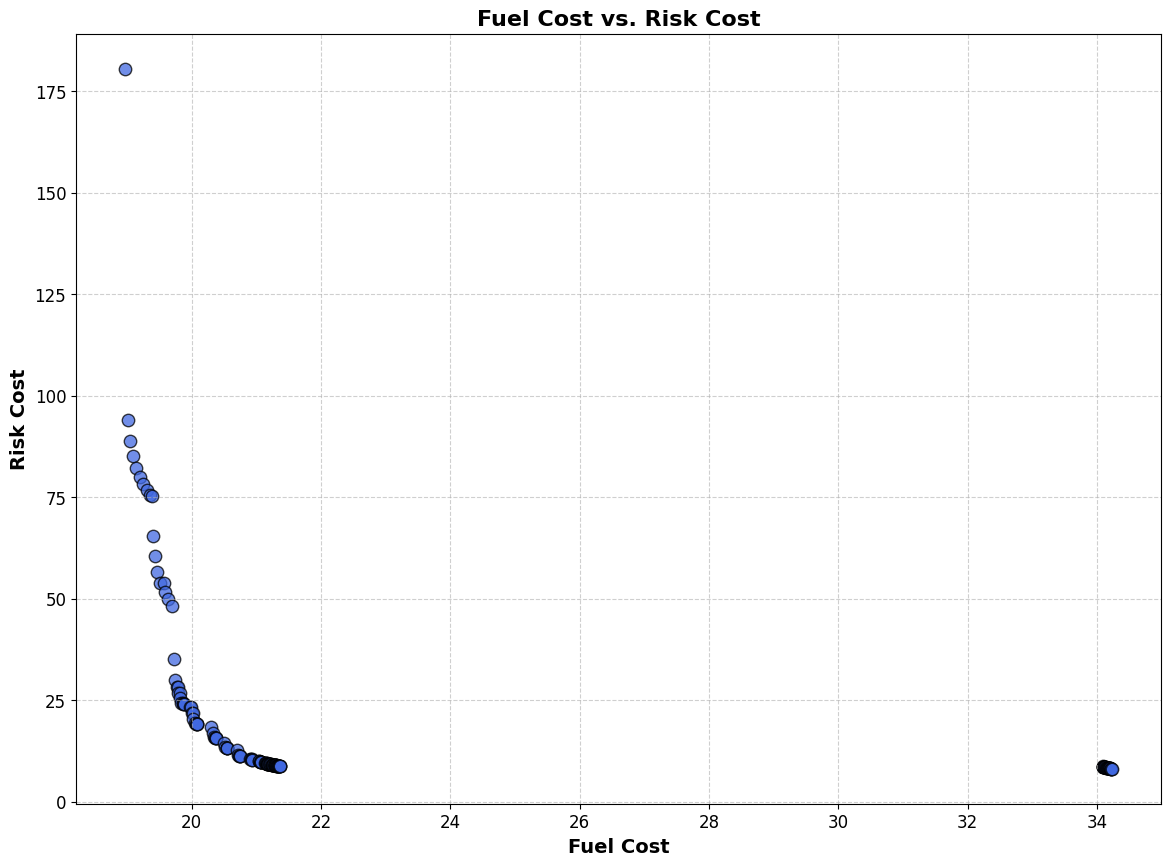

Extracted Solution Paths:
['s', 24, 7, 58, 46, 'g', (18.9720075212978, 180.508381822238)]
['s', 24, 8, 58, 46, 'g', (19.0184554790541, 93.9646205337760)]
['s', 24, 8, 57, 46, 'g', (19.0449673698721, 88.8176857497057)]
['s', 24, 8, 57, 47, 'g', (19.0866747803097, 85.0843789524698)]
['s', 24, 8, 56, 47, 'g', (19.1317706425192, 82.2562547617937)]
['s', 24, 8, 55, 47, 'g', (19.2048750677282, 80.0348368346055)]
['s', 24, 8, 55, 48, 'g', (19.2521060274539, 78.2341213232118)]
['s', 24, 8, 54, 48, 'g', (19.3092653829047, 76.7322254585660)]
['s', 24, 8, 54, 49, 'g', (19.3509498298477, 75.4456469669873)]
['s', 24, 8, 54, 53, 49, 'g', (19.3859238262883, 75.1868451474712)]
['s', 23, 8, 58, 46, 'g', (19.3988191806486, 65.5699938648224)]
['s', 23, 8, 57, 46, 'g', (19.4253310714666, 60.4230590807521)]
['s', 23, 8, 57, 47, 'g', (19.4670384819041, 56.6897522835162)]
['s', 23, 8, 56, 47, 'g', (19.5121343441137, 53.8616280928401)]
['s', 23, 8, 57, 48, 'g', (19.5690615024462, 53.8616280928401)]
['s', 23, 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
import heapq
import time

# =============================================================================
# Constants, UAV parameters, and initial conditions
# =============================================================================

# Define QZ circles as tuples (x, y, radius)
map_qz = [(0.0, 0.0, 6.0), (12.0, 10.0, 4.0)]
start = (-5, -5)       # Starting point
goal = (15, 15)        # Goal point

# UAV characteristics
alpha = 0.5
recharge_factor = 2
beta = alpha / recharge_factor

q_min, q_max, q_act = 20, 100, 50
discretization_angle = 10

# Risk limits (temporary) and an index map for circles
risk_limit = {circle: 30 for circle in map_qz}
circle_index_map = {i: circle for i, circle in enumerate(map_qz)}

# =============================================================================
# Graph Construction and Node Creation
# =============================================================================

# Instantiate the graph construction object.
# (Assuming you have already refactored your class into GraphConstructionDiscretization.)
graph_object = GraphConstructionDiscretization(
    map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle
)

# Create nodes and the index maps.
nodes, index_map, reverse_index_map = graph_object.create_nodes()

def build_visibility_graph(graph_obj, rev_index_map, qz_circles):
    """
    Builds the visibility graph by adding internal and external edges between nodes.
    
    Args:
        graph_obj: Instance of GraphConstructionDiscretization.
        rev_index_map: Mapping of node indices to node information.
        qz_circles: List of QZ circles.
        
    Returns:
        visibility_graph: A directed graph (nx.DiGraph) with added edges.
    """
    visibility_graph = nx.DiGraph()
    # Iterate over all pairs of nodes
    for i, node_i in rev_index_map.items():
        for j, node_j in rev_index_map.items():
            if i == j:
                continue

            circle_i, circle_j = node_i[2], node_j[2]
            x_i, y_i = node_i[0], node_i[1]
            x_j, y_j = node_j[0], node_j[1]

            # Case 1: Internal edge if both nodes are from the same circle
            if circle_i == circle_j:
                graph_obj.internal_edge_addition(i, node_i, j, node_j, visibility_graph)
            else:
                # For external edges, check if any QZ circle intersects the line segment
                intersection_exists = False
                for circle in qz_circles:
                    if graph_obj.line_segment_intersects_circle(circle, (x_i, y_i), (x_j, y_j)):
                        intersection_exists = True
                        break
                if not intersection_exists:
                    graph_obj.external_edge_addition(i, node_i, j, node_j, visibility_graph)
    return visibility_graph


def assign_heuristic_costs(visibility_graph, rev_index_map, goal, qz_circles, q_act, alpha, beta):
    """
    Assigns a heuristic cost for each node based on its Euclidean distance to the goal.
    
    Args:
        visibility_graph: The graph with nodes.
        rev_index_map: Mapping from node index to node tuple.
        goal: Goal point as (x, y).
        qz_circles: List of QZ circles.
        q_act: The state-of-charge value.
        alpha: UAV parameter.
        beta: UAV parameter.
    """
    # Define the goal node tuple. The circle index for the goal is set to len(qz_circles)+1.
    goal_node = (goal[0], goal[1], len(qz_circles) + 1, q_act)
    for i, node in rev_index_map.items():
        # Compute Euclidean distance using sympy (for consistency with the rest of the code)
        distance = sp.sqrt((goal_node[0] - node[0])**2 + (goal_node[1] - node[1])**2)
        heuristic_cost = (alpha / (alpha + beta)) * distance
        visibility_graph.nodes[i]['heuristic_cost'] = heuristic_cost


# Build the visibility graph
visibility_graph = build_visibility_graph(graph_object, reverse_index_map, map_qz)

# Assign heuristic cost to each node
assign_heuristic_costs(visibility_graph, reverse_index_map, goal, map_qz, q_act, alpha, beta)

# =============================================================================
# Biobjective Optimization (Search)
# =============================================================================

def biobjective_search(visibility_graph, start_state="s", goal_state="g", reduce_factor=1):
    """
    Performs a biobjective search (fuel cost and risk cost) over the visibility graph.
    
    Args:
        visibility_graph: The directed graph with nodes and weighted edges.
        start_state: Identifier for the start node (default "s").
        goal_state: Identifier for the goal node (default "g").
        reduce_factor: A factor used in pruning dominated paths.
        
    Returns:
        sols: A dict mapping each state to a list of solution tuples.
        g2_min: A dict mapping each state to its minimum risk cost.
    """
    all_states = list(visibility_graph.nodes)
    print("All states:", all_states)
    sols = {state: [] for state in all_states}
    g2_min = {state: np.inf for state in all_states}
    open_set = []

    # The start node is represented as a tuple: (f1, f2, g1, g2, state)
    # and its parent is set to None.
    start_node = (0, 0, 0, 0, start_state)
    heapq.heappush(open_set, [start_node, (None, None, None, None, None)])

    while open_set:
        current_node, parent_node = heapq.heappop(open_set)
        current_f1, current_f2, current_g1, current_g2, current_state = current_node

        # Prune if the current risk cost is dominated
        if (current_g2 >= reduce_factor * g2_min[current_state] or
            current_f2 >= reduce_factor * g2_min[goal_state]):
            continue

        g2_min[current_state] = current_g2
        sols[current_state].append([current_node, parent_node])

        # Stop expanding if the goal is reached
        if current_state == goal_state:
            continue

        # Expand successors of the current state
        for successor in visibility_graph.successors(current_state):
            edge_data = visibility_graph.edges[current_state, successor]
            g1 = current_g1 + edge_data['fuel_cost']
            f1 = g1 + visibility_graph.nodes[successor]['heuristic_cost']
            g2 = current_g2 + edge_data['risk_cost']
            # For risk, we use a zero heuristic.
            f2 = g2

            # Prune dominated successors
            if (g2 >= reduce_factor * g2_min[successor] or
                f2 >= reduce_factor * g2_min[goal_state]):
                continue

            child_node = (f1, f2, g1, g2, successor)
            heapq.heappush(open_set, [child_node, current_node])
    return sols, g2_min


# Run the biobjective search
start_state = "s"
goal_state = "g"
sols, g2_min = biobjective_search(visibility_graph, start_state, goal_state, reduce_factor=1)

# =============================================================================
# Pareto Optimality Check and Plotting
# =============================================================================

def extract_costs(solutions, target_state):
    """
    Extracts fuel and risk cost values for a given target state from the solutions.
    
    Args:
        solutions: Dict mapping states to solution tuples.
        target_state: The state for which to extract cost values.
        
    Returns:
        fuel_costs: List of fuel cost values.
        risk_costs: List of risk cost values.
    """
    fuel_costs = [sol[0][0] for sol in solutions[target_state]]
    risk_costs = [sol[0][1] for sol in solutions[target_state]]
    return fuel_costs, risk_costs


def check_pareto_optimality(fuel_costs, risk_costs):
    """
    Checks for dominance among the solutions and returns the indices of dominated solutions.
    
    Args:
        fuel_costs: List of fuel cost values.
        risk_costs: List of risk cost values.
        
    Returns:
        dominated_indices: List of indices corresponding to dominated solutions.
    """
    dominated_indices = []
    n = len(fuel_costs)
    for i in range(n):
        for j in range(i + 1, n):
            if fuel_costs[i] <= fuel_costs[j] and risk_costs[i] <= risk_costs[j]:
                dominated_indices.append(i)
            elif fuel_costs[i] >= fuel_costs[j] and risk_costs[i] >= risk_costs[j]:
                dominated_indices.append(j)
    return dominated_indices


# Extract cost values for the goal state
fuel_costs, risk_costs = extract_costs(sols, goal_state)

# Check Pareto optimality
dominated_indices = check_pareto_optimality(fuel_costs, risk_costs)
print("Dominated solution indices:", dominated_indices)


def plot_costs(fuel_costs, risk_costs):
    """
    Plots a scatter plot of fuel cost versus risk cost.
    
    Args:
        fuel_costs: List of fuel cost values.
        risk_costs: List of risk cost values.
    """
    plt.figure(figsize=(14, 10))
    plt.scatter(fuel_costs, risk_costs, color='royalblue', edgecolors='black',
                alpha=0.75, s=80)
    plt.xlabel("Fuel Cost", fontsize=14, fontweight='bold')
    plt.ylabel("Risk Cost", fontsize=14, fontweight='bold')
    plt.title("Fuel Cost vs. Risk Cost", fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


# Plot the results
plot_costs(fuel_costs, risk_costs)

# =============================================================================
# Reconstructing Solution Paths
# =============================================================================

def reconstruct_solution_paths(solutions, start_state="s", goal_state="g"):
    """
    Reconstructs paths from the start state to the goal state using the parent links stored in solutions.
    
    Each solution is a tuple of the current node and its parent. The node tuple is in the form:
        (f1, f2, g1, g2, state)
    
    Returns:
        solution_paths: A list of paths. Each path is a list of states followed by a cost tuple.
    """
    solution_paths = []
    # Iterate over each solution for the goal state
    for current_node, parent_node in solutions[goal_state]:
        path = [current_node[-1]]  # start with the goal state
        cost = (current_node[0], current_node[1])
        # Traverse backward through the parent links
        parent_state = parent_node[-1] if parent_node[4] is not None else None
        curr_node, par_node = current_node, parent_node
        while parent_state is not None and parent_state != start_state:
            found = False
            for sol in solutions[parent_state]:
                if sol[0] == par_node:
                    curr_node, par_node = sol
                    path.append(curr_node[-1])
                    parent_state = par_node[-1]
                    found = True
                    break
            if not found:
                break
        if par_node is not None:
            path.append(par_node[-1])
        path.reverse()
        # Append the associated cost tuple at the end of the path
        path.append(cost)
        solution_paths.append(path)
    return solution_paths


# Reconstruct and print all solution paths
solution_paths = reconstruct_solution_paths(sols, start_state, goal_state)
print("Extracted Solution Paths:")
for spath in solution_paths:
    print(spath)


# =============================================================================
# End of Pipeline
# =============================================================================


In [8]:
# import random
# ##### Plotting the solution path for which passes thru certain state
# plt.figure(figsize=(14, 10))
# random.seed(42)
# colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(len(paths_with_22_xy))]

# for i, path in enumerate(paths_with_22_xy):
#     x, y = zip(*path)
#     plt.plot(x, y, marker='o', linestyle='-', color=colors[i], label=f'{float(paths_with_22[i][-1][0]):.2f},{float(paths_with_22[i][-1][1]):.2f}')

# for x_c, y_c, r in Map_qz:
#     circle = plt.Circle((x_c, y_c), r, color='gray', alpha=0.3, fill=True)
#     plt.gca().add_patch(circle)

# ### Start and goal points
# plt.scatter(start[0], start[0], color='black', marker='s', s=100, label='Start' )
# plt.scatter(goal[0], goal[0], color='red', marker='*', s=150, label='Goal')

# # Formatting
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.axis("equal")  # Ensure aspect ratio is equal
# plt.grid(True)
# plt.title("Paths with Circles and Start/Goal Points")
# plt.show()

In [9]:
# #### Modified BOAstar with only subset of solutions
# alpha_mod, beta_mod = 0.7, 0.7
# M_alpha_beta = np.array([[alpha_mod, 1-alpha_mod], [1-beta_mod, beta_mod]])

# sols = { state: [] for state in all_states}
# g2_min = { state: np.inf for state in all_states}
# open_set = []

# x =  [(0, 0, 0, 0,"s"), (None,None,None,None,None) ] ### start node (f1, f2, g1, g2, start state) and its parent node as None, x = ( start_node, parent_node)

# goal_state = "g"
# heapq.heappush(open_set, x)
# count = 0

# while open_set:
#     node_expand = heapq.heappop(open_set)
#     current_f1, current_f2, current_g1, current_g2, current_state  = node_expand[0]
    
#     ### 1. if g2[node] >= g2_min[node] don't add
#     ### 2. if f2[node] >= g2_min[goal] don't add
#     if current_g2 >= g2_min[current_state] or current_f2 >= g2_min[goal_state]:
#         continue
    
#     g2_min[current_state] = current_g2
#     sols[current_state].append(node_expand)
    
#     if current_state == goal_state:
#         continue
    
#     for state in visibility_graph.successors(current_state):
#         edge_g1 = visibility_graph.edges[current_state, state]['fuel_cost']
#         edge_g2 = visibility_graph.edges[current_state, state]['risk_cost']
#         edge_h = visibility_graph.nodes[state]['heuristic_cost']
        
#         edge_g1_mod = alpha_mod*edge_g1 + (1-alpha_mod)*edge_g2
#         edge_g2_mod = beta_mod*edge_g2  + (1-beta_mod)*edge_g1
#         edge_h1_mod = alpha_mod*edge_h
#         edge_h2_mod = (1-beta_mod)*edge_h

#         g1 = current_g1 + edge_g1_mod
#         f1 = g1 + edge_h1_mod
        
#         g2 = current_g2 + edge_g2_mod
#         f2 = g2 + edge_h2_mod ### Zero heuristic for risk.
        
#         # print(f"Total child node state: {x}")
#         ### Prune if dominated
#         if g2 >= g2_min[state] or f2 >= g2_min[goal_state]:
#             continue
        
#         child_node =[ (f1, f2, g1, g2, state), (current_f1, current_f2, current_g1, current_g2, current_state)]
#         ### Else putting the node in the open set
#         heapq.heappush(open_set, child_node)
        
#     # count += 1

In [10]:
# fuel_cost = np.array([ float(node[0][0]) for node in sols["g"]])
# risk_cost = np.array([ float(node[0][1]) for node in sols["g"]])

# M_inv = np.linalg.inv(M_alpha_beta)
# fuel_cost = M_inv[0,0]*fuel_cost + M_inv[0,1]*risk_cost
# risk_cost = M_inv[1,0]*fuel_cost + M_inv[1,1]*risk_cost
# ### Scattter plot of fuel cost vs risk cost
# plt.figure(figsize=(14, 10))
# plt.scatter(fuel_cost, risk_cost, color='royalblue', edgecolors='black', alpha=0.75, s=80)  # Larger, more visible points
# plt.xlabel("Fuel Cost", fontsize=14, fontweight='bold')
# plt.ylabel("Risk Cost", fontsize=14, fontweight='bold')
# plt.title("Fuel Cost vs. Risk Cost", fontsize=16, fontweight='bold')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# plt.show()

In [11]:
# #### All the path extracted from the solution
# solution_paths = []
# for current, parent in sols["g"]:
#     parent_state = parent[-1]
#     single_path = [current[-1]]
#     while parent_state != "s":
#         for parent_loop, grandparent_loop in sols[parent_state]:
#             if parent_loop == parent:
#                 current = parent
#                 parent, parent_state = grandparent_loop, grandparent_loop[-1]
#                 single_path.append(current[-1])
#                 break
#     single_path.append(parent[-1])
#     single_path.reverse()
#     solution_paths.append(single_path)

# solution_paths